# 2. Import libraries and read data

In [1]:
import joblib
import optuna
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls


In [2]:
data = pd.read_csv('Diabetes.csv')
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


# 3. Data Preprocessing 

## 3.1 Data Describe and visualization

The DataFrame.describe() method provides descriptive statistics summarizing the distribution of a dataset's numeric values, excluding NaN values. It offers insights into the central tendency, dispersion, and shape. Notably, it doesn't handle categorical values unless include="all" is specified. The generated statistics include count, mean, standard deviation, minimum and maximum values, and quartile information, aiding in outlier detection.

In [3]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Glucose,768.0,120.894531,31.972618,0.000,99.00000,117.0000,140.25000,199.00
BloodPressure,768.0,69.105469,19.355807,0.000,62.00000,72.0000,80.00000,122.00
SkinThickness,768.0,20.536458,15.952218,0.000,0.00000,23.0000,32.00000,99.00
Insulin,768.0,79.799479,115.244002,0.000,0.00000,30.5000,127.25000,846.00
BMI,768.0,31.992578,7.884160,0.000,27.30000,32.0000,36.60000,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00
Outcome,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00


In [4]:
#gives information about the data types,columns, null value counts, memory usage etc

data.info()   

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [5]:
data.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

In [6]:
data.rename(columns = {'DiabetesPedigreeFunction':'DPF'}, inplace = True)
data.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DPF', 'Age', 'Outcome'],
      dtype='object')

In [7]:
duplicate = data[data.duplicated()]
 
print("Duplicate Rows :",duplicate)

Duplicate Rows : Empty DataFrame
Columns: [Pregnancies, Glucose, BloodPressure, SkinThickness, Insulin, BMI, DPF, Age, Outcome]
Index: []


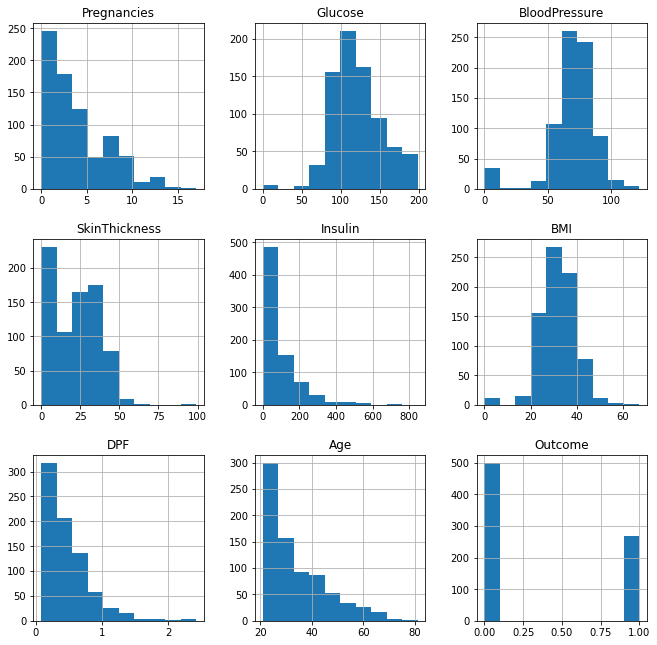

In [8]:
data.hist(figsize=(11,11));

As observed in the histogram charts, the data's distribution reveals that glucose, BMI, and blood pressure exhibit nearly normal distributions.

## 3.2 Manage Missing Value

In [9]:
data.isnull().sum()

Pregnancies      0
Glucose          0
BloodPressure    0
SkinThickness    0
Insulin          0
BMI              0
DPF              0
Age              0
Outcome          0
dtype: int64

In [10]:
print((data == 0).sum())

Pregnancies      111
Glucose            5
BloodPressure     35
SkinThickness    227
Insulin          374
BMI               11
DPF                0
Age                0
Outcome          500
dtype: int64


There are numerous zeros in the data columns, with some, like insulin and BMI, being invalid as they cannot be zero. This suggests that zero values might have been used in place of NaN values. Consequently, **we need to replace all the zeros in these columns with NaN values.**

In [11]:
data[['Glucose','BloodPressure','SkinThickness',
      'Insulin','BMI']] = data[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']].replace(0,np.NaN)

In [12]:
data.isnull().sum()

Pregnancies        0
Glucose            5
BloodPressure     35
SkinThickness    227
Insulin          374
BMI               11
DPF                0
Age                0
Outcome            0
dtype: int64

In [13]:
Missing_value = pd.DataFrame({"Count":data.isnull().sum(),"Percentage":round(100*data.isnull().sum()/data.count().max(), 2)})

Missing_value.T

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DPF,Age,Outcome
Count,0.0,5.00,35.00,227.00,374.0,11.00,0.0,0.0,0.0
Percentage,0.0,0.65,4.56,29.56,48.7,1.43,0.0,0.0,0.0


In [14]:
data_copy = data.copy(deep=True)

To handle missing data, we remove rows from the dataset that contain more than 70% NaN values. This step is crucial to avoid potential errors in the final results.

In [15]:
#only keep rows with at least 70% non-NaN values

data_copy=data_copy.dropna(thresh=0.7*len(data_copy.columns))  

In [16]:
data_copy.shape

#removed 35 rows by at least 70% non-NaN values

(733, 9)

We replace the remaining missing data values in each column with the average value of the data (mean) for that specific column. Additionally, to enhance accuracy, we compute the average of the output data based on the class labels (Outcome).

In [17]:
#Applying Only on variables with NaN values

for i in data_copy.columns[data_copy.isnull().any(axis=0)]:     
    data_copy[i] = data_copy.groupby(["Outcome"])[i].transform(lambda x: x.fillna(x.mean()))

## 3.3 Manage Outlier Data

### 3.3.1 Manage Outliers Data with IQR method

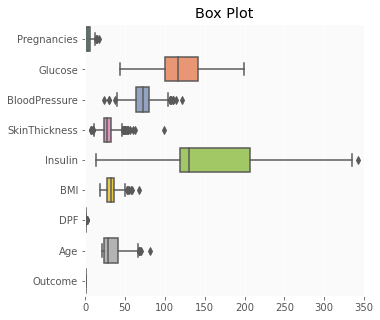

In [18]:
plt.style.use('ggplot') # Using ggplot2 style visuals 

f, ax = plt.subplots(figsize=(5, 5))

ax.set_facecolor('#fafafa')
ax.set(xlim=(-.05, 350))
plt.title("Box Plot")
ax = sns.boxplot(data = data_copy, 
  orient = 'h', 
  palette = 'Set2')

### 3.3.2 Finding the boundary values

In [19]:
Q1  = pd.DataFrame()
Q3  =   pd.DataFrame()
IQR =  pd.DataFrame()
UpperLimit =  pd.DataFrame()
LowerLimit =  pd.DataFrame()
Outlier_UpperLimit =  pd.DataFrame(index=[1,2,3,4])
Outlier_LowerLimit =  pd.DataFrame(index=[1,2,3,4])

columns = data_copy.columns[0:-1]

for i in columns:
    Q1[i] = [data_copy[i].quantile(0.25)]
    Q3[i]=  [data_copy[i].quantile(0.75)]
    IQR[i] = [Q3[i][0]-Q1[i][0]]
    UpperLimit[i] = [Q3[i][0]+1.5*IQR[i][0]]
    LowerLimit[i] = [Q1[i][0]-1.5*IQR[i][0]]

In [20]:
df = pd.concat([Q1,Q3,IQR,UpperLimit,LowerLimit])
df.index = ["Q1","Q3","IQR","UpperLimit","LowerLimit"]
dft = df.T
dft

,Q1,Q3,IQR,UpperLimit,LowerLimit
Pregnancies,1.000,6.000000,5.000000,13.500000,-6.500000
Glucose,100.000,142.000000,42.000000,205.000000,37.000000
BloodPressure,64.000,80.000000,16.000000,104.000000,40.000000
SkinThickness,24.000,33.000000,9.000000,46.500000,10.500000
Insulin,119.000,206.846154,87.846154,338.615385,-12.769231
BMI,27.500,36.600000,9.100000,50.250000,13.850000
DPF,0.245,0.629000,0.384000,1.205000,-0.331000
Age,24.000,41.000000,17.000000,66.500000,-1.500000



### 3.3.3 Find the outliers

In [21]:
aa =[]
print("Upper Limit Outlier: ","\n")
for i in columns:
    aa = np.array(data_copy[data_copy[i]>dft["UpperLimit"][i]][i])
        
    print("{} Outliers: {}".format(i,aa))


Upper Limit Outlier:  

Pregnancies Outliers: [15 17 14 14]
Glucose Outliers: []
BloodPressure Outliers: [110. 108. 122. 110. 108. 110. 106. 106. 106. 114.]
SkinThickness Outliers: [47. 47. 60. 54. 51. 56. 50. 54. 50. 52. 48. 49. 63. 48. 52. 49. 47. 99.
 50. 47. 48. 49. 48.]
Insulin Outliers: [543. 846. 342. 495. 485. 495. 478. 744. 370. 680. 402. 375. 545. 360.
 465. 415. 579. 474. 480. 600. 440. 540. 480. 387. 392. 510.]
BMI Outliers: [53.2 55.  67.1 52.3 52.9 59.4 57.3]
DPF Outliers: [2.288 1.441 1.39  1.893 1.781 1.222 1.4   1.321 1.224 2.329 1.318 1.213
 1.353 1.224 1.391 1.476 2.137 1.731 1.268 1.6   2.42  1.251 1.699 1.258
 1.282 1.698 1.461 1.292 1.394]
Age Outliers: [69 67 81 67 67 70 68]


In [22]:
xx =[]
print("Lower Limit Outlier: ","\n")

for i in columns:
    xx = np.array(data_copy[data_copy[i]<dft["LowerLimit"][i]][i])
    
    print("{} Outliers: {}".format(i,xx))


Lower Limit Outlier:  

Pregnancies Outliers: []
Glucose Outliers: []
BloodPressure Outliers: [30. 30. 24. 38.]
SkinThickness Outliers: [10.  7. 10. 10.  8.  8. 10.  7. 10.]
Insulin Outliers: []
BMI Outliers: []
DPF Outliers: []
Age Outliers: []


### 3.3.4 Cap the Outliers

Given the small number of our data, we opt to employ the data **capping** method rather than deleting outlier data. This approach involves replacing data larger than the upper limit with that value and data smaller than the lower limit with that value.

In [23]:
columns_cap = ["Insulin","SkinThickness","DPF","Pregnancies","BloodPressure","BMI","Age"]

def Cap_Outliers(dff,column):
    for i in column:
        print('Working on column: {}'.format(i))
        dff[i] = np.where(dff[i]>dft["UpperLimit"][i],dft["UpperLimit"][i],
                            np.where(dff[i]<dft["LowerLimit"][i],dft["LowerLimit"][i],dff[i]))
    return dff

Cap_Outliers(data_copy,columns_cap)

Working on column: Insulin
Working on column: SkinThickness
Working on column: DPF
Working on column: Pregnancies
Working on column: BloodPressure
Working on column: BMI
Working on column: Age


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DPF,Age,Outcome
0,6.0,148.0,72.0,35.0,206.846154,33.6,0.627,50.0,1
1,1.0,85.0,66.0,29.0,130.287879,26.6,0.351,31.0,0
2,8.0,183.0,64.0,33.0,206.846154,23.3,0.672,32.0,1
3,1.0,89.0,66.0,23.0,94.000000,28.1,0.167,21.0,0
4,0.0,137.0,40.0,35.0,168.000000,43.1,1.205,33.0,1
...,...,...,...,...,...,...,...,...,...
763,10.0,101.0,76.0,46.5,180.000000,32.9,0.171,63.0,0
764,2.0,122.0,70.0,27.0,130.287879,36.8,0.340,27.0,0
765,5.0,121.0,72.0,23.0,112.000000,26.2,0.245,30.0,0
766,1.0,126.0,60.0,33.0,206.846154,30.1,0.349,47.0,1


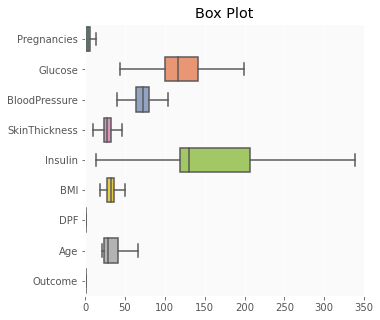

In [24]:
plt.style.use('ggplot') # Using ggplot2 style visuals 

f, ax = plt.subplots(figsize=(5, 5))

ax.set_facecolor('#fafafa')
ax.set(xlim=(-.05, 350))
plt.title("Box Plot")
ax = sns.boxplot(data = data_copy, 
  orient = 'h', 
  palette = 'Set2')

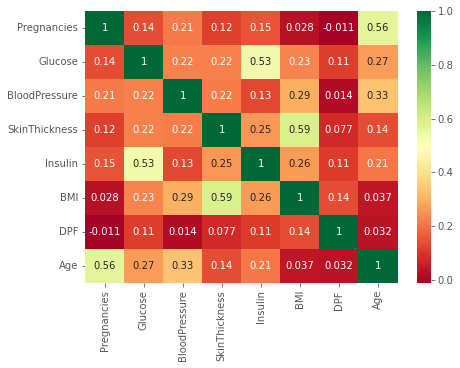

In [25]:
sns.heatmap(data_copy[data_copy.columns[:8]].corr(),annot=True,cmap='RdYlGn')
fig=plt.gcf()
fig.set_size_inches(7,5)
plt.show()

[Text(0.5, 1.0, 'Kendall correlation')]

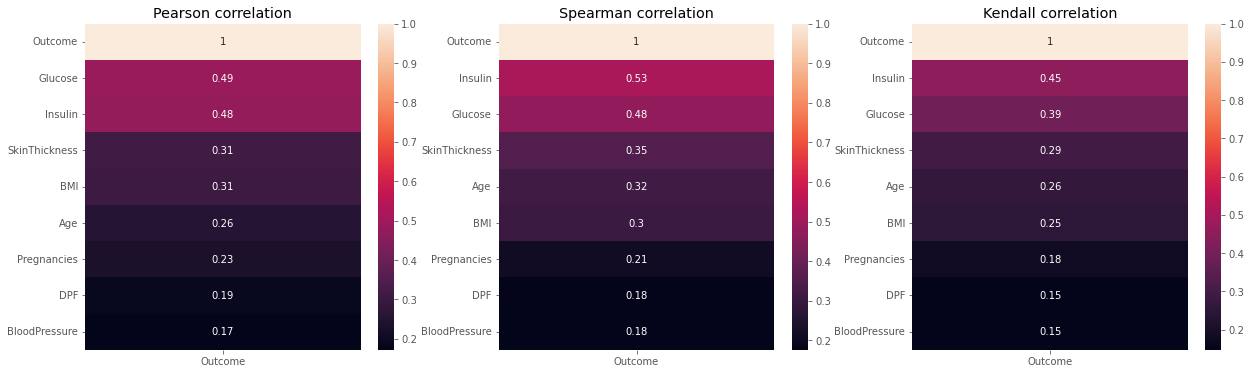

In [26]:
fig, ax = plt.subplots(1,3, figsize=(21, 6))

corr1 = data_copy.corr('pearson')[['Outcome']].sort_values(by='Outcome', ascending=False)
corr2 = data_copy.corr('spearman')[['Outcome']].sort_values(by='Outcome', ascending=False)
corr3 = data_copy.corr('kendall')[['Outcome']].sort_values(by='Outcome', ascending=False)


sns.heatmap(corr1, ax=ax[0], annot=True).set(title='Pearson correlation')
sns.heatmap(corr2, ax=ax[1], annot=True).set(title='Spearman correlation')
sns.heatmap(corr3, ax=ax[2], annot=True).set(title='Kendall correlation')

In [28]:
#save cleaned data as csv file

data_copy.to_csv("data_cln.csv",index=False)
